This notebook is used to fine-tune GPT2 model for text classification using [Huggingface](https://huggingface.co/transformers/) [transformers](https://github.com/huggingface/transformers) library on a custom dataset. Hugging Face is very nice to us to include all the functionality needed for GPT2 to be used in classification tasks. 

**Main idea:**
Since GPT2 is a decoder transformer, the last token of the input sequence is used to make predictions about the next token that should follow the input. This means that the last token of the input sequence contains all the information needed in the prediction. With this in mind we can use that information to make a prediction in a classification task instead of generation task. In other words, instead of using first token embedding to make prediction like we do in Bert, we will use the last token embedding to make prediction with GPT2.

Since we only cared about the first token in Bert, we were padding to the right. Now in GPT2 we are using the last token for prediction so we will need to pad on the left. Because of a nice upgrade to HuggingFace Transformers we are able to configure the GPT2 Tokenizer to do just that.
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Installs

* **[transformers](https://github.com/huggingface/transformers)** library needs to be installed to use all the awesome code from Hugging Face. To get the latest version we will install it straight from GitHub.

* **[ml_things](https://github.com/gmihaila/ml_things)** library used for various machine learning related tasks. We used this library to reduce the amount of code we need to write for each machine learning project.


In [ ]:
!pip uninstall imgaug
!pip install imgaug == 0.2.5

In [ ]:
# Install transformers library
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
     |████████████████████████████████| 53 kB 1.5 MB/s 
     |████████████████████████████████| 11.2 MB 8.6 MB/s 
     |████████████████████████████████| 930 kB 62.6 MB/s 


Import libraries and declare parameters used for this notebook.

In [ ]:
# Preliminaries
import io
import os, re
import torch
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed, TrainingArguments, Trainer, GPT2Config, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup, GPT2ForSequenceClassification)

# Set seed for reproducibility
set_seed(1)
# Number of training epochs
epochs = 10
# Number of batches - depending on the max sequence length and GPU memory
batch_size = 64
# Pad or truncate text sequences to a specific length
max_length = 100
# Look for GPU to use. We will use `CPU` by default if no GPU found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Use pretrained model
model_name_or_path = 'gpt2'
# Dictionary of labels and their ids. This will be used to convert string labels to number ids
labels_ids = {'unrelated': 0, 'agree': 1, 'discuss': 2, 'disagree': 3}
# Number of labels we use
n_labels = len(labels_ids)

In [ ]:
# Load the pretrained Word2Vec model by Google
w2v_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary = True)

##Helper Functions


**MovieReviewsDataset(Dataset)**

We use this class to read in our dataset, parse it and return texts with their associated labels. There are three main parts of this PyTorch Dataset class:

* **init()** where we read in the dataset and transform text and labels into numbers.
* **len()** where we need to return the number of examples we read in. This is used when calling len(MovieReviewsDataset()).
* **getitem()** always takes as an input an int value that represents which example from our examples to return from our dataset. If a value of 3 is passed, we will return the example form our dataset at position 3.


**Gpt2ClassificationCollator**

We use this class to create the Data Collator. This will be used in the DataLoader to create the bathes of data that get fed to the model. We use the tokenizer and label encoder on each sequence to convert texts and labels to number. There are two main parts of this Data Collator class:

* **init()** where we initialize the tokenizer we plan to use, how to encode our labels and if we need to set the sequence length to a different value.
* **__call__()** used as function collator that takes as input a batch of data examples. It needs to return an object with the format that can be fed to our model. Luckily our tokenizer does that for us and returns a dictionary of variables ready to be fed to the model in this way: `model(**inputs)`. Since we are fine-tuning the model I also included the labels.


**train(dataloader, optimizer_, scheduler_, device_)**

We created this function to perform a full pass through the DataLoader object (the DataLoader object is created from our Dataset* type object using the **MovieReviewsDataset class). This is basically one epoch train through the entire dataset.

The optimizer_ and scheduler_ are very common in PyTorch. They are required to update the parameters of our model and update our learning rate during training. 

In the process we keep track of the actual labels and the predicted labels along with the loss.


**validation(dataloader, device_)**

We implemented this function in a very similar way as train but without the parameters update, backward pass and gradient decent part. We don't need to do all of those computationally intensive tasks because we only care about our model's predictions.

We use the DataLoader in a similar way as in train to get out batches to feed to our model.

In the process we keep track of the actual labels and the predicted labels along with the loss.


In [ ]:
# Load stopword list
with open("/content/drive/MyDrive/stopwords.txt", newline = '') as f:
    stopwords = f.readlines()[0].split(',')

# Define a function to remove special characters and stowpords
def rm_spec_char_stopwords(line):
    line = re.sub('[!"#$%&()*+/:;<=>@[\\]^`{|}~\r\t\n.-?~_,0-9]+', '', line).lower().split(' ')
    for word in stopwords:
        # If a stopword is in the line, remove it
        while word in line:
            idx = line.index(word)
            line.pop(idx)
    return line

In [ ]:
class FNCDataset():
    r"""PyTorch dataset class for loading data. This is where the data parsing happens
    Arguments:
        path (:obj:`str`): Path to the data partition.
    """

    def __init__(self, use_tokenizer):

        # Declare a list for all texts and their labels
        self.texts = []
        self.labels = []

        # Load data
        data_bodies = pd.read_csv("/content/drive/MyDrive/fnc-1-baseline-master/fnc-1/train_bodies.csv").reset_index(drop = True)
        data_stances = pd.read_csv("/content/drive/MyDrive/fnc-1-baseline-master/fnc-1/train_stances.csv").reset_index(drop = True)
        data = pd.merge(data_bodies, data_stances, how = 'outer', on = 'Body ID')
        data = data.drop(['Body ID'], axis = 1)

        # Remove special characters and stopwords
        data['articleBody'] = data['articleBody'].apply(lambda x: rm_spec_char_stopwords(x))
        data['Headline'] = data['Headline'].apply(lambda x: rm_spec_char_stopwords(x))
        data['feature'] = data['articleBody'] + data['Headline']
        data = data.drop(['articleBody', 'Headline'], axis = 1)
        data['feature'] = data['feature'].apply(lambda x: ' '.join(x))

        for i in range(len(data)):
            self.texts.append(data['feature'][i])
            self.labels.append(data['Stance'][i])

        # Number of samples
        self.n_examples = len(self.labels)

        return

    def __len__(self):
        r"""When used `len` return the number of examples.
        """
        
        return self.n_examples

    def __getitem__(self, item):
        r"""Given an index return an example from the position.
        Arguments:
            item (:obj:`int`): Index position to pick an example to return.
        Returns:
            :obj:`Dict[str, str]`: Dictionary of inputs that contain text and asociated labels.
        """

        return {'text': self.texts[item],
                'label': self.labels[item]}


class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. It uses a given tokenizer and label encoder to convert any text and labels to numbers that can go straight into a GPT2 model.
    Arguments:
        use_tokenizer (:obj:`transformers.tokenization_?`): Transformer type tokenizer used to process raw text into numbers.
        labels_ids (:obj:`dict`): Dictionary to encode any labels names into numbers. Keys map to labels names and Values map to number associated to those labels.
        max_sequence_len (:obj:`int`, `optional`): Value to indicate the maximum desired sequence to truncate or pad text sequences.                                                 If no value is passed it will used maximum sequence size supported by the tokenizer and model.
    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len = None):

        # Tokenizer to be used inside the class
        self.use_tokenizer = use_tokenizer
        # Check max sequence length
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call. Sine the PyTorch DataLoader needs a collator function, we can use this class as a function.
        Arguments:
            item (:obj:`list`): List of texts and labels.
        Returns:
            :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model. It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with appropriate padding
        inputs = self.use_tokenizer(text = texts, return_tensors = "pt", padding = True, truncation = True,  max_length = self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor
        inputs.update({'labels': torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
    r"""
    Train pytorch model on a single pass through the data loader.
    It will use the global variable `model` which is the transformer model loaded on `_device` that we want to train on.
    Arguments:
        dataloader (:obj:`torch.utils.data.dataloader.DataLoader`): Parsed data into batches of tensors.
        optimizer_ (:obj:`transformers.optimization.AdamW`): Optimizer used for training.
        scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`): PyTorch scheduler.
        device_ (:obj:`torch.device`): Device used to load tensors before feeding to model.
    Returns:
        :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted Labels, Train Average Loss].
    """

    # Use global variable for model
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch
    total_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for batch in tqdm(dataloader, total = len(dataloader)):

        # Add original labels - use later for evaluation
        true_labels += batch['labels'].numpy().flatten().tolist()
        
        # Move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
        
        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch)
        # This will return the loss (rather than the model output) because we have provided the `labels`
        # The documentation for this a bert model function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits
        # We will use logits later to calculate training accuracy
        loss, logits = outputs[:2]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer_.step()

        # Update the learning rate
        scheduler_.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Convert these logits to list of predicted labels values
        predictions_labels += logits.argmax(axis = -1).flatten().tolist()

    # Calculate the average loss over the training data
    avg_epoch_loss = total_loss / len(dataloader)
    
    # Return all true labels and prediction for future evaluations
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_):
    r"""Validation function to evaluate model performance on a separate set of data.
    This function will return the true and predicted labels so we can use later to evaluate the model's performance.
    Arguments:
        dataloader (:obj:`torch.utils.data.dataloader.DataLoader`): Parsed data into batches of tensors.
        device_ (:obj:`torch.device`): Device used to load tensors before feeding to model.
    Returns:
        :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted Labels, Train Average Loss]
    """

    # Use global variable for model
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total = len(dataloader)):

        # Add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()

        # Move batch to device
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            # This will return the logits rather than the loss because we have not provided labels
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(**batch)

            # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits
            # We will use logits later to to calculate training accuracy
            loss, logits = outputs[:2]
            
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. `loss` is a Tensor containing a single value;
            # the `.item()` function just returns the Python value from the tensor
            total_loss += loss.item()
            
            # Get predicitons to list
            predict_content = logits.argmax(axis = -1).flatten().tolist()

            # Update list
            predictions_labels += predict_content

    # Calculate the average loss over the training data
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediciton for future evaluations
    return true_labels, predictions_labels, avg_epoch_loss

##Load Model and Tokenizer

Loading the three essential parts of the pretrained GPT2 transformer: configuration, tokenizer and model. For this example we use `gpt2` from HuggingFace pretrained transformers.

HuggingFace already did most of the work for us and added a classification layer to the GPT2 model. In creating the model we used `GPT2ForSequenceClassification`. Since we have a custom padding token we need to initialize it for the model using `model.config.pad_token_id`.
Finally we will need to move the model to the device we defined earlier.



In [ ]:
# Get model configuration
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# Resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# Fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


##Dataset and Collator

This is where we create the PyTorch Dataset and Data Loader with Data Collator objects that will be used to feed data into our model. The data collator is used to format the PyTorch Dataset outputs to match the inputs needed for GPT2.

In [ ]:
# Create data collator to encode text and labels into numbers
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer = tokenizer, 
                                                          labels_encoder = labels_ids, 
                                                          max_sequence_len = max_length)

print('Dealing with Train...')
# Create pytorch dataset
train_dataset = FNCDataset(use_tokenizer = tokenizer)
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), len(train_dataset) - int(len(train_dataset) * 0.9)])
print('Created `train_dataset` with %d examples!' % len(train_dataset))
print('Created `val_dataset` with %d examples!' % len(val_dataset))

# Move pytorch dataset into dataloader
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = gpt2_classificaiton_collator)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!' % len(train_dataloader))
print('Created `val_dataloader` with %d batches!' % len(val_dataloader))

Dealing with Train...
Created `train_dataset` with 44974 examples!
Created `val_dataset` with 4998 examples!
Created `train_dataloader` with 703 batches!
Created `val_dataloader` with 79 batches!


##Train

We created optimizer and scheduler use by PyTorch in training. We used most common parameters used by transformers models.

We looped through the number of defined epochs and call the **train** and **validation** functions.

We are trying to output similar info after each epoch as Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

Epoch


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.75399 - val_loss: 0.61701 - train_acc: 0.73576 - val_acc: 0.76551



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


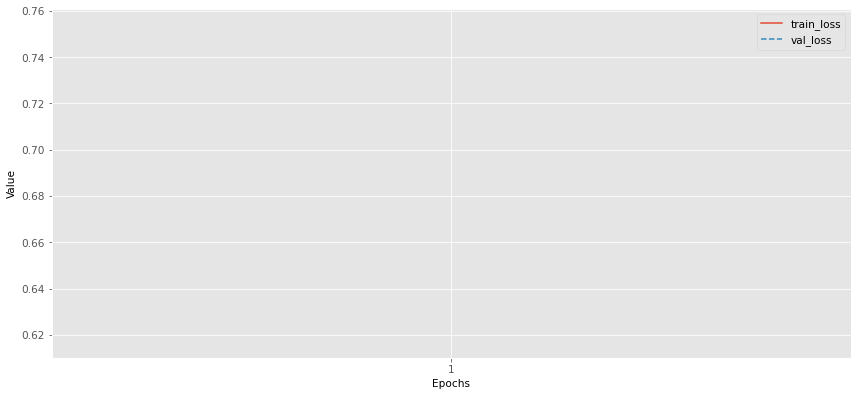

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


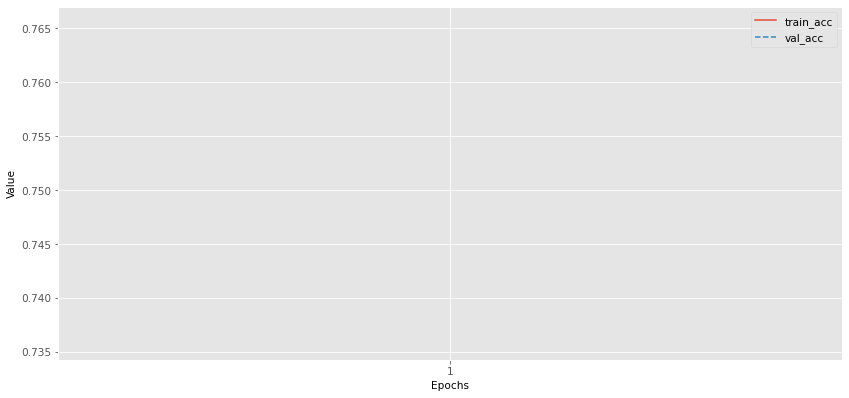


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.59078 - val_loss: 0.56439 - train_acc: 0.78192 - val_acc: 0.78611



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


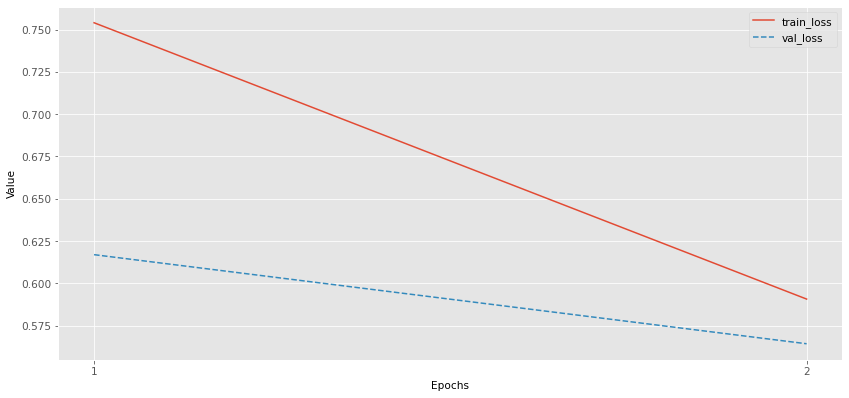

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


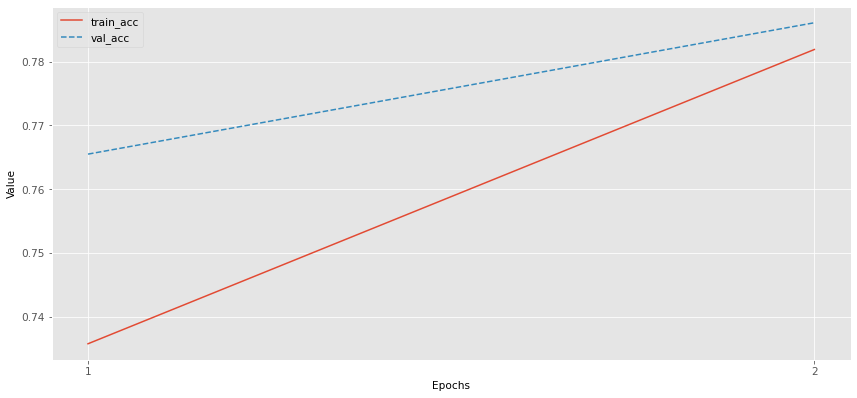


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.54033 - val_loss: 0.52614 - train_acc: 0.79975 - val_acc: 0.80292



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


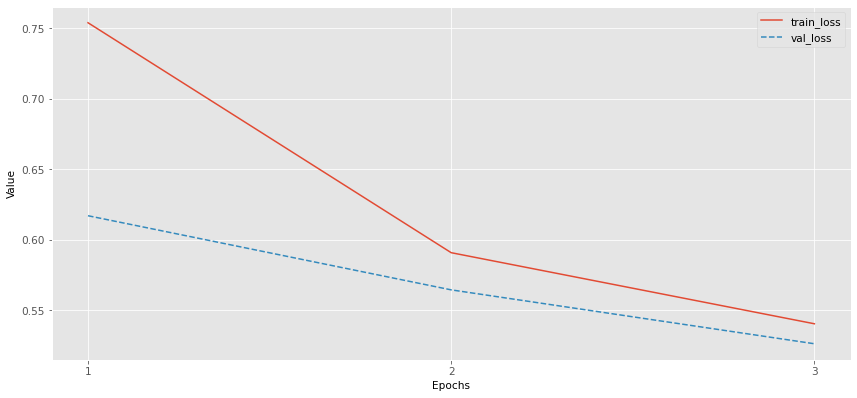

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


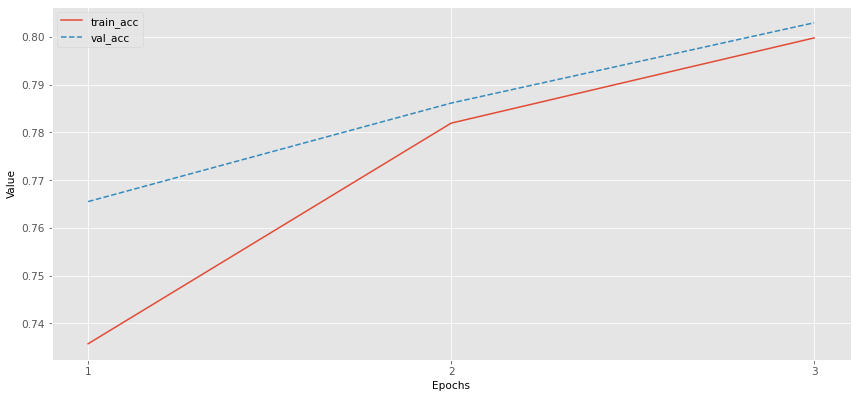


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.51285 - val_loss: 0.52424 - train_acc: 0.80778 - val_acc: 0.80512



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


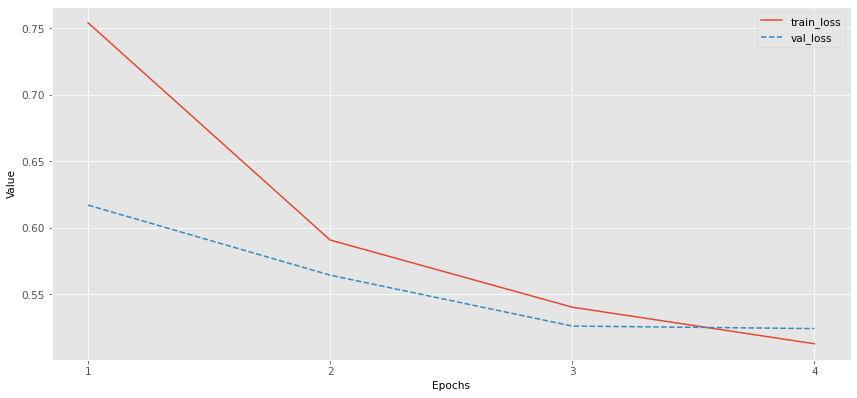

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


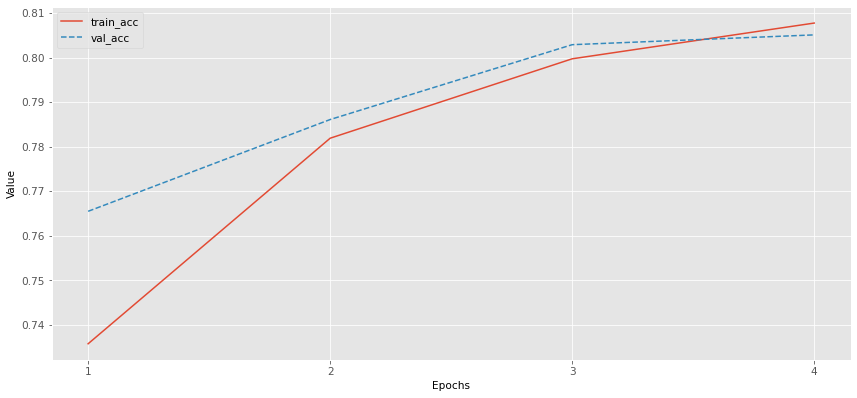


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.49468 - val_loss: 0.49354 - train_acc: 0.81469 - val_acc: 0.81513



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


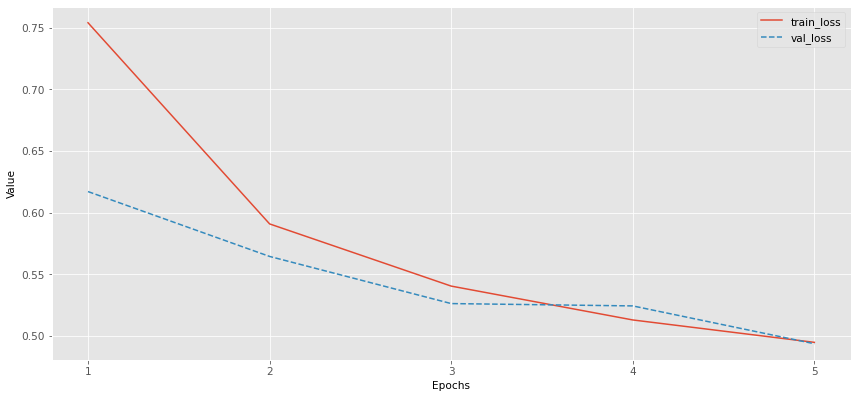

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


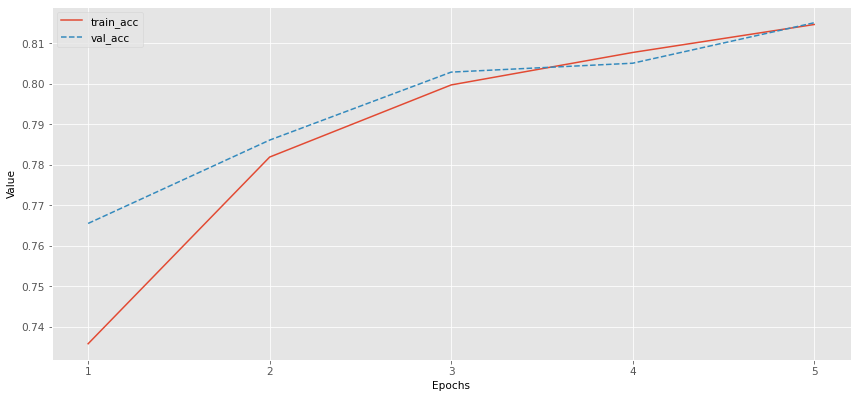


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.48159 - val_loss: 0.49287 - train_acc: 0.81874 - val_acc: 0.81873



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


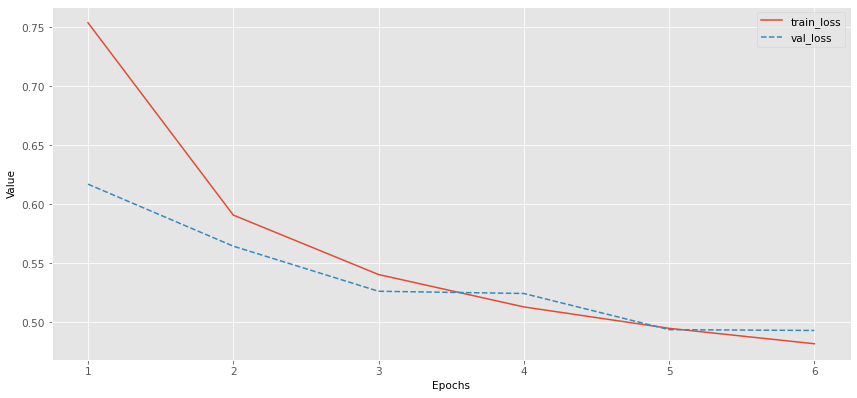

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


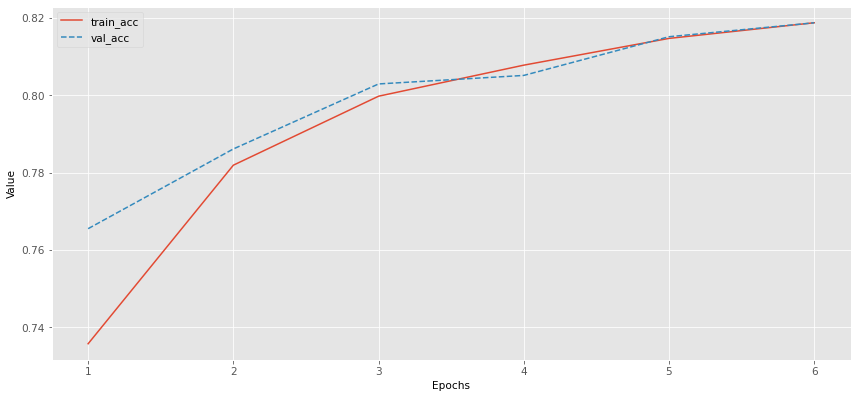


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.47236 - val_loss: 0.49416 - train_acc: 0.81967 - val_acc: 0.81993



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


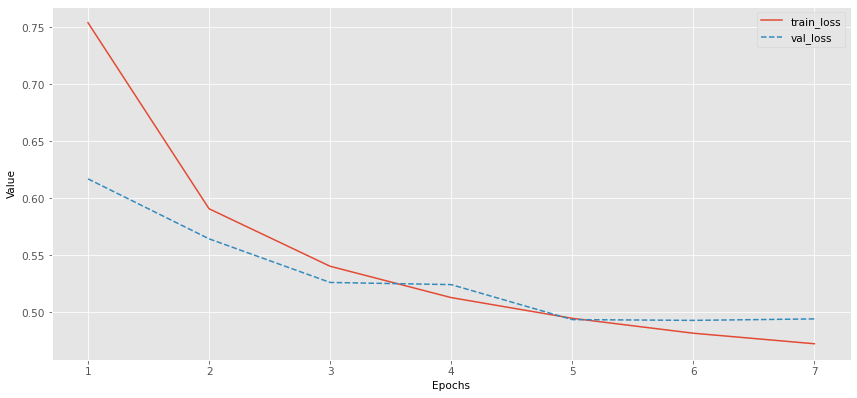

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


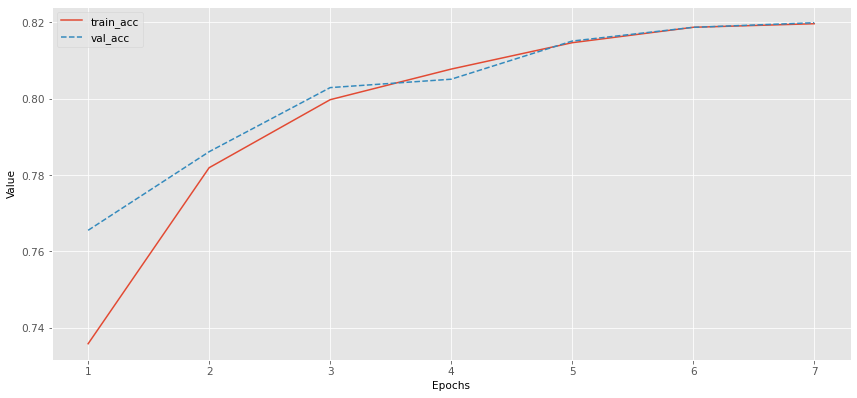


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.46630 - val_loss: 0.49426 - train_acc: 0.82245 - val_acc: 0.82073



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


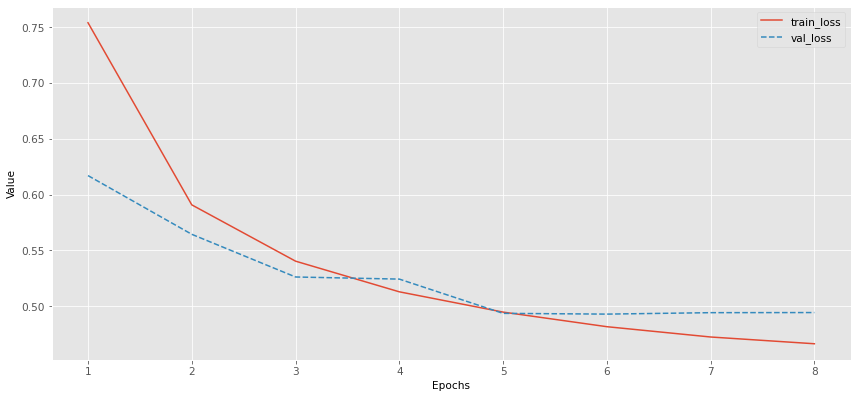

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


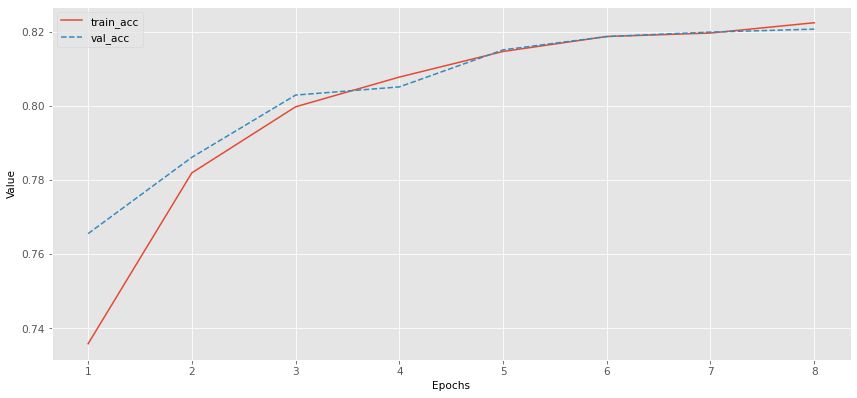


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.46152 - val_loss: 0.48893 - train_acc: 0.82390 - val_acc: 0.81653



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


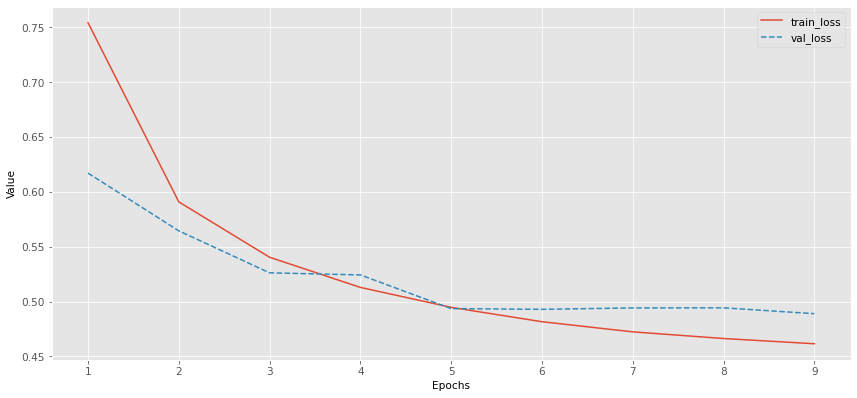

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


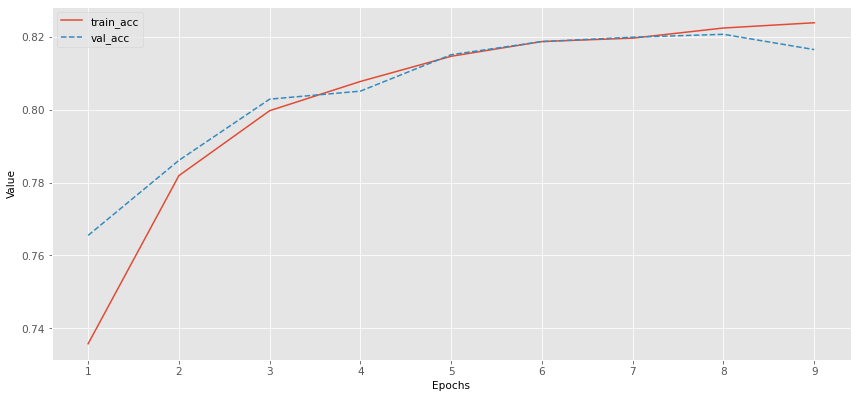


Training on batches...


  0%|          | 0/703 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/79 [00:00<?, ?it/s]

  train_loss: 0.45530 - val_loss: 0.48801 - train_acc: 0.82606 - val_acc: 0.81973



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


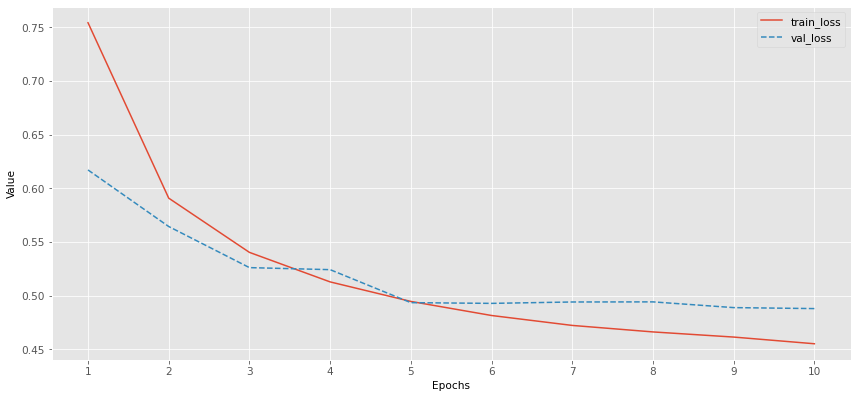

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


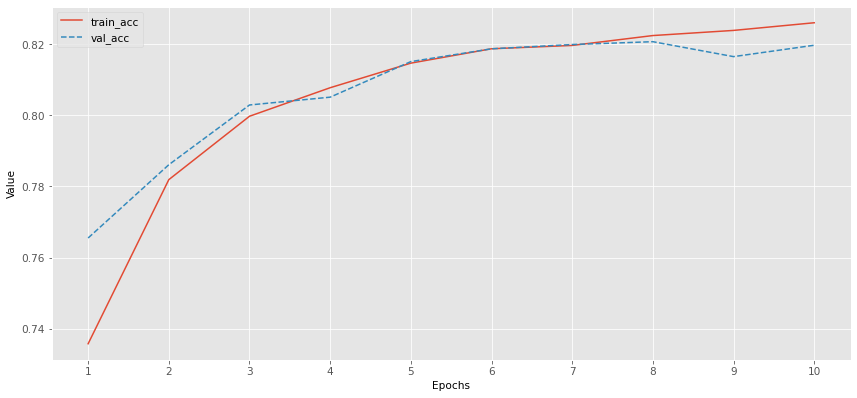

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,   # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

# Loop through each epoch
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data
    print('Validation on batches...')
    val_labels, val_predict, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(val_labels, val_predict)

    # Print loss and accuracy values to see how training evolves
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - val_acc: %.5f" % (train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves
plot_dict(all_loss, use_xlabel = 'Epochs', use_ylabel = 'Value', use_linestyles = ['-', '--'])

# Plot accuracy curves
plot_dict(all_acc, use_xlabel = 'Epochs', use_ylabel = 'Value', use_linestyles = ['-', '--'])

## **Evaluate**

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

   unrelated       0.86      0.95      0.90      3682
       agree       0.55      0.39      0.46       334
     discuss       0.71      0.52      0.60       893
    disagree       0.47      0.24      0.31        89

    accuracy                           0.82      4998
   macro avg       0.65      0.52      0.57      4998
weighted avg       0.80      0.82      0.81      4998

Normalized confusion matrix


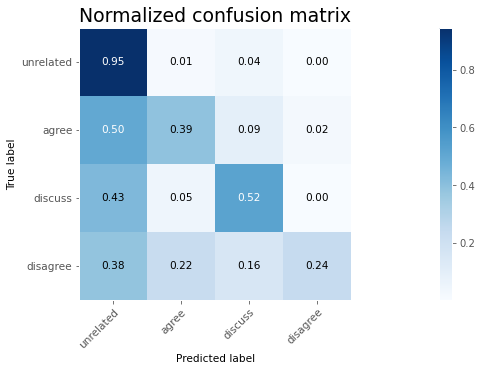

In [ ]:
# Get prediction form model on validation data. This is where you should use your test data
true_labels, predictions_labels, avg_epoch_loss = validation(val_dataloader, device)

# Create the evaluation report
evaluation_report = classification_report(true_labels, predictions_labels, labels = list(labels_ids.values()), target_names = list(labels_ids.keys()))
# Show the evaluation report
print(evaluation_report)

# Plot confusion matrix
plot_confusion_matrix(y_true = true_labels, y_pred = predictions_labels, classes = list(labels_ids.keys()), normalize = True, magnify = 0.1)